Using saas.csv

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
   - Last Observed Value
   - Simple Average
   - Moving Average
   - Holt's Linear Trend
   - Holt's Seasonal Trend
3. Based on previous year/month/etc., this is up to you.

In [3]:
import prepare as p

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [4]:
df = pd.read_csv('saas.csv')

In [5]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [7]:
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)
df = df.set_index('Month_Invoiced').sort_index()

In [8]:
df = df.resample('d')[['Amount']].sum()

In [9]:
df.index.min(), df.index.max()

(Timestamp('2014-01-31 00:00:00', freq='D'),
 Timestamp('2017-12-31 00:00:00', freq='D'))

Amount


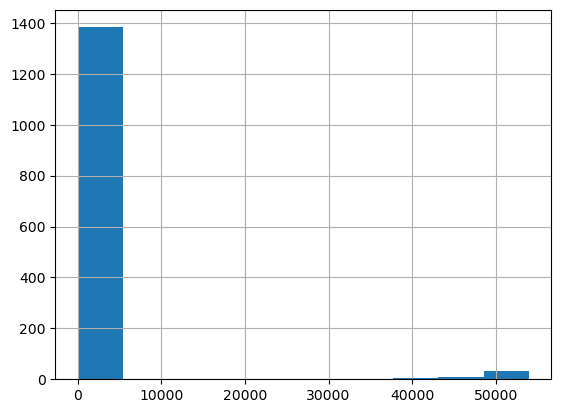

In [10]:
for col in df.columns:
    print(col)
    df[col].hist()
    plt.show()

### 1. Data split

In [11]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

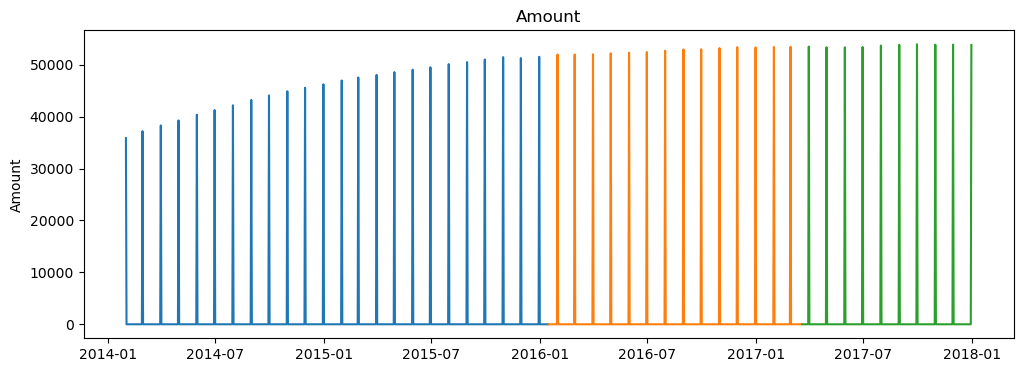

In [12]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### 2. Forecast

In [13]:
# take the last item of sales total and assign to variable
last_amount = train['Amount'][-1:][0]


yhat_df = pd.DataFrame(
    {'total_amount': [last_amount]},
    index=validate.index)

yhat_df.head()

,total_amount
Month_Invoiced,
2016-01-16,0.0
2016-01-17,0.0
2016-01-18,0.0
2016-01-19,0.0
2016-01-20,0.0


In [16]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [17]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return pd.concat([eval_df, d])

## Last Observed Value

In [22]:

def last_observed_value(series):
    last_value = series.iloc[-1]
    forecast = [last_value] * len(series)
    
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Actual')
    plt.plot(series.index, forecast, label='Last Observed Value')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Last Observed Value Forecast')
    plt.legend()
    plt.show()

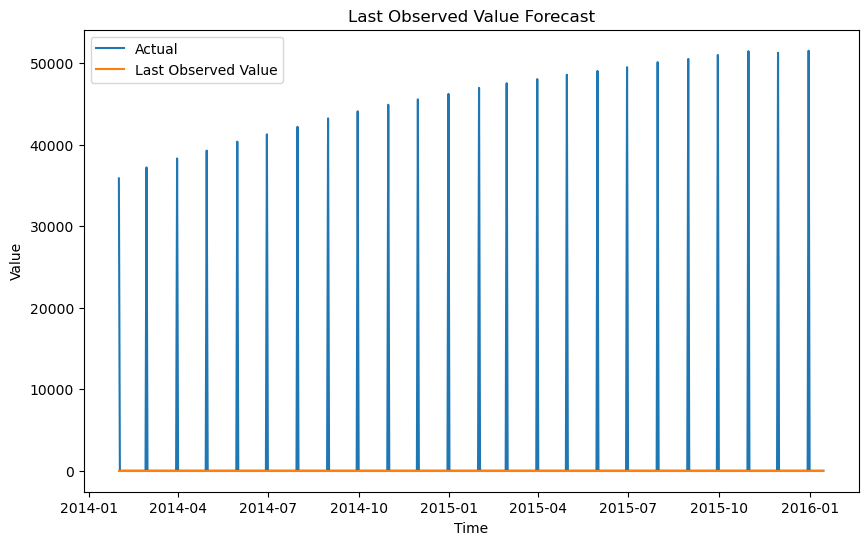

In [23]:
last_observed_value(train)

## Simple Average:

In [24]:
def simple_average(series):
    average_value = series.mean()
    forecast = [average_value] * len(series)
    
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Actual')
    plt.plot(series.index, forecast, label='Simple Average')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Simple Average Forecast')
    plt.legend()
    plt.show()

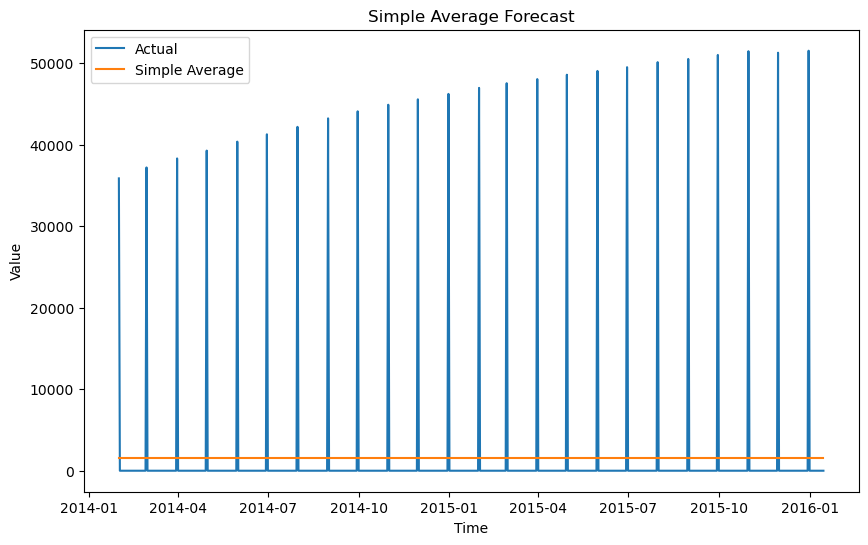

In [25]:
simple_average(train)

## Moving Average

In [27]:
def moving_average(series, window_size):
    forecast = series.rolling(window=window_size).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Actual')
    plt.plot(series.index, forecast, label='Moving Average')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Moving Average Forecast (Window Size: {window_size})')
    plt.legend()
    plt.show()

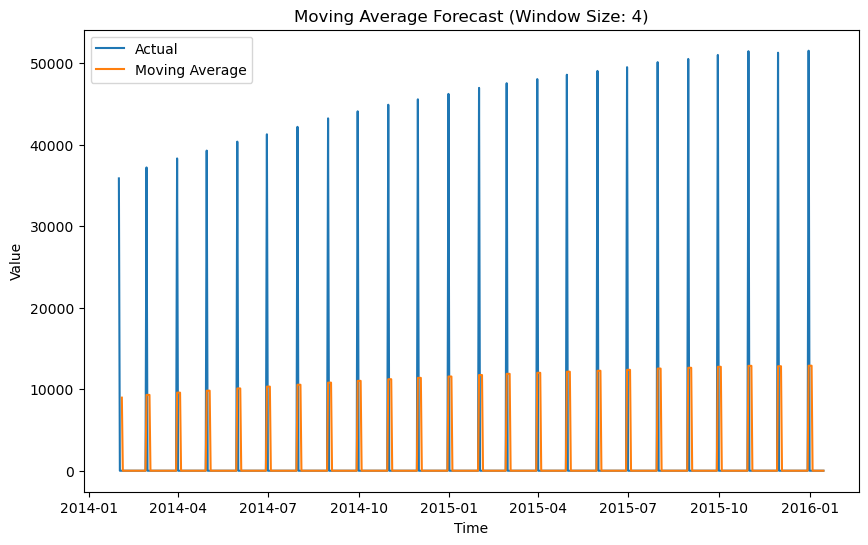

In [30]:
moving_average(train,4)

## Holt's Linear Trend

In [31]:
def holt_linear_trend(series, forecast_length):
    # Fit Holt's Linear Trend model
    model = ExponentialSmoothing(series, trend='add', damped_trend=False).fit()

    # Generate forecasts
    forecast = model.predict(start=len(series), end=len(series)+forecast_length-1)

    # Plot the actual values and the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Actual')
    plt.plot(forecast.index, forecast.values, label='Holt Linear Trend')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Holt Linear Trend Forecast')
    plt.legend()
    plt.show()

    return forecast

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


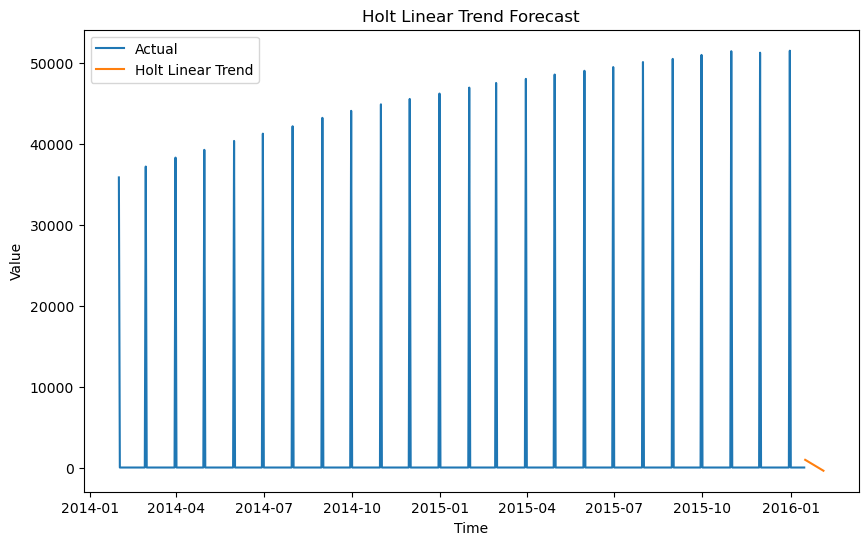

2016-01-16    951.671708
2016-01-17    880.735995
2016-01-18    809.800282
2016-01-19    738.864569
2016-01-20    667.928855
2016-01-21    596.993142
2016-01-22    526.057429
2016-01-23    455.121716
2016-01-24    384.186003
2016-01-25    313.250290
2016-01-26    242.314577
2016-01-27    171.378864
2016-01-28    100.443150
2016-01-29     29.507437
2016-01-30    -41.428276
2016-01-31   -112.363989
2016-02-01   -183.299702
2016-02-02   -254.235415
2016-02-03   -325.171128
2016-02-04   -396.106842
Freq: D, dtype: float64

In [35]:
holt_linear_trend(train,20)